# When to buy Bitcoin - custom CNN indicator

Custom technical indicator using CNN and data from Cryptomon API (https://api.cryptomon.io/swagger-ui.html). For more info about perfomance or implementation, please check original repository: https://github.com/kimber-chen/Tensorflow-for-stock-prediction.

### API Credentials

To obtain API credentials, follow these instructions:
1. Create new Premium Account: https://cryptomon.io/create-account
2. API credentials under Account information: https://cryptomon.io/account#api


### Run Python code

To run the code below:

1. Click on the cell to select it.
2. Press `SHIFT+ENTER` on your keyboard or press the play button (<button class='fa fa-play icon-play btn btn-xs btn-default'></button>) in the toolbar above.

A full tutorial for using the notebook interface is available [here](ipython_examples/Notebook/Index.ipynb).


In [1]:
## Some imports

% matplotlib inline

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from tensorflow.python.ops import clip_ops
from bn_class import *

import sys
sys.path.append("../API_Client/") 

from ApiClient import ApiClient

In [2]:
## Hyperparameters

num_filt_1 = 15     #Number of filters in first conv layer
num_filt_2 = 8      #Number of filters in second conv layer
num_filt_3 = 8      #Number of filters in thirs conv layer
num_fc_1 = 1024     #Number of neurons in hully connected layer
max_iterations = 8000
model_num=5         #Number of model used for voting
voting_times=1      #Threshold of voting
batch_size = 50
dropout = 0.5       #Dropout rate in the fully connected layer
plot_row = 5        #How many rows do you want to plot in the visualization
regularization = 1e-4
learning_rate = 2e-3
input_norm = False   # Do you want z-score input normalization?
np.set_printoptions(threshold=np.inf)#print full array


In [3]:
## Cryptomon API credentials

CLIENT_ID = "<API_CLIENT_ID>"
CLIENT_SECRET = "<API_CLIENT_SECRET>"

c = ApiClient(CLIENT_ID, CLIENT_SECRET)
c.request_access()

params = {
    "market" : "BITSTAMP",
    "currencyPair" : "BTC_USD",
    "period" : "ONE_HOUR",
    "ascending" : "false"
}
rows = c.get("https://api.cryptomon.io/api/v1/candles", params)
print("rows: {}".format(len(rows)))
# print("rows: {}".format(rows))

Requesting access_token...
Success, access_token: fe3821db-23ab-4153-b4a7-02584dc8d45f, expires_in: 37
Request, url: https://api.cryptomon.io/api/v1/candles, params: {'ascending': 'false', 'currencyPair': 'BTC_USD', 'period': 'ONE_HOUR', 'market': 'BITSTAMP'}
Success, status_code: 200
rows: 1147


In [4]:
## Prepare data

data_x = []
r=[]
for count, item in enumerate(rows, 1): # Start counting from 1
    r.append(item['close'])
    if count % 10 == 0:
        data_x.append(r[::-1]) # reverse
        r = []

print("data_x.len: {}".format(len(data_x)))
data_x = data_x[::-1] # reverse
# print("data_x: {}".format(data_x))

data_x.len: 114


In [5]:
## Mark data

def get_change(current, previous):
    if current == previous:
        return 100.0
    try:
        return ((current - previous)/previous)*100.0
    except ZeroDivisionError:
        return 0

def mark_data(item, rows):
    rows_flat = sum(rows, [])
    # print("item: {}".format(item))
    # print("rows_flat: {}".format(rows_flat))
    
    if not rows_flat:
        return False
    
    i_max = max(item)
    i_min = min(item)
    
    r_max = max(rows_flat)
    r_min = min(rows_flat)
    
    # price_series = pd.Series(rows_flat)
    # change = price_series.pct_change()
    # print("change: {}".format(change))
    
    # print("r_max: {}".format(r_max))
    # print("i_min: {}".format(i_min))
    
    change = get_change(r_max, i_min)
    # print("change: {}".format(change))
    
    # 5 % change in 10 days
    if(change > 5):
        return True
    return False
    

data_x_c = data_x[:]
for index, item in enumerate(data_x):     
    # 10 days
    data = data_x[(index + 1): (index + 2)]
    #print("index: {}".format(index))
    #print("len.data_x: {}".format(len(data_x)))
    #print("len.data: {}".format(len(data)))
    
    if(mark_data(item, data)):
        data_x_c[index].insert(0, 1)
    else: 
        data_x_c[index].insert(0, 0)   
        
data_x_c = np.array(data_x_c)
data_x_c = np.around(data_x_c, decimals=2)

# Last 200 bars is used for test
data_train = data_x_c[:-20]
# data_train = data_x_c[:]
print("data_train: {}".format(len(data_train)))
# print("data_train: {}".format(data_train))

# data_test = np.array(data_x_c[:])  
data_test = np.array(data_x_c[-20:])
print("data_test: {}".format(len(data_test)))
# print("data_test: {}".format(data_test))   


data_train: 94
data_test: 20


In [6]:
## Split training and testing data

X_train = data_train[:,1:] # [:,1:] - slice columns, all without first column
X_test = data_test[:,1:]
N = X_train.shape[0]
Ntest = X_test.shape[0]
D = X_train.shape[1]
y_train = data_train[:,0]
y_test = data_test[:,0]

In [7]:
## Normalize x and y

num_classes = len(np.unique(y_train))
base = np.min(y_train)  #Check if data is 0-based
if base != 0:
    y_train -=base
    y_test -= base

if input_norm:
    mean = np.mean(X_train,axis=0)
    variance = np.var(X_train,axis=0)
    X_train -= mean
    #The 1e-9 avoids dividing by zero
    X_train /= np.sqrt(variance)+1e-9
    X_test -= mean
    X_test /= np.sqrt(variance)+1e-9

In [8]:
epochs = np.floor(batch_size*max_iterations / N)
print('Train with approximately %d epochs' %(epochs))


Train with approximately 4255 epochs


In [9]:
## Start training model
## Place for the input variables

total_rst=np.zeros((model_num,len(y_test)), dtype=np.float)
for xx in range(0,model_num):
    print("Training at model "+str(xx))
    x = tf.placeholder("float", shape=[None, D], name = 'Input_data')
    y_ = tf.placeholder(tf.int64, shape=[None], name = 'Ground_truth')
    keep_prob = tf.placeholder("float")
    bn_train = tf.placeholder(tf.bool)          #Boolean value to guide batchnorm

    ## w and b and conv function
    def weight_variable(shape, name):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, name = name)

    def bias_variable(shape, name):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial, name = name)

    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_2x2(x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')

    with tf.name_scope("Reshaping_data") as scope:
        x_image = tf.reshape(x, [-1,D,1,1])

    ## Build the graph
    # ewma is the decay for which we update the moving average of the 
    # mean and variance in the batch-norm layers
    with tf.name_scope("Conv1") as scope:
        W_conv1 = weight_variable([4, 1, 1, num_filt_1], 'Conv_Layer_1')
        b_conv1 = bias_variable([num_filt_1], 'bias_for_Conv_Layer_1')
        a_conv1 = conv2d(x_image, W_conv1) + b_conv1
    
    with tf.name_scope('Batch_norm_conv1') as scope:
        ewma = tf.train.ExponentialMovingAverage(decay=0.99)                  
        bn_conv1 = ConvolutionalBatchNormalizer(num_filt_1, 0.001, ewma, True)           
        update_assignments = bn_conv1.get_assigner() 
        a_conv1 = bn_conv1.normalize(a_conv1, train=bn_train) 
        h_conv1 = tf.nn.relu(a_conv1)
    
    with tf.name_scope("Conv2") as scope:
        W_conv2 = weight_variable([4, 1, num_filt_1, num_filt_2], 'Conv_Layer_2')
        b_conv2 = bias_variable([num_filt_2], 'bias_for_Conv_Layer_2')
        a_conv2 = conv2d(h_conv1, W_conv2) + b_conv2
    
    with tf.name_scope('Batch_norm_conv2') as scope:
        bn_conv2 = ConvolutionalBatchNormalizer(num_filt_2, 0.001, ewma, True)           
        update_assignments = bn_conv2.get_assigner() 
        a_conv2 = bn_conv2.normalize(a_conv2, train=bn_train) 
        h_conv2 = tf.nn.relu(a_conv2)
      
    with tf.name_scope("Conv3") as scope:
        W_conv3 = weight_variable([4, 1, num_filt_2, num_filt_3], 'Conv_Layer_3')
        b_conv3 = bias_variable([num_filt_3], 'bias_for_Conv_Layer_3')
        a_conv3 = conv2d(h_conv2, W_conv3) + b_conv3
    
    with tf.name_scope('Batch_norm_conv3') as scope:
        bn_conv3 = ConvolutionalBatchNormalizer(num_filt_3, 0.001, ewma, True)           
        update_assignments = bn_conv3.get_assigner() 
        a_conv3 = bn_conv3.normalize(a_conv3, train=bn_train) 
        h_conv3 = tf.nn.relu(a_conv3)

    with tf.name_scope("Fully_Connected1") as scope:
        W_fc1 = weight_variable([D*num_filt_3, num_fc_1], 'Fully_Connected_layer_1')
        b_fc1 = bias_variable([num_fc_1], 'bias_for_Fully_Connected_Layer_1')
        h_conv3_flat = tf.reshape(h_conv3, [-1, D*num_filt_3])
        h_fc1 = tf.nn.relu(tf.matmul(h_conv3_flat, W_fc1) + b_fc1)
    
    with tf.name_scope("Fully_Connected2") as scope:
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
        W_fc2 = tf.Variable(tf.truncated_normal([num_fc_1, num_classes], stddev=0.1),name = 'W_fc2')
        b_fc2 = tf.Variable(tf.constant(0.1, shape=[num_classes]),name = 'b_fc2')
        h_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2   
    with tf.name_scope("SoftMax") as scope:
        regularizers = (tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(b_conv1) +
                      tf.nn.l2_loss(W_conv2) + tf.nn.l2_loss(b_conv2) + 
                      tf.nn.l2_loss(W_conv3) + tf.nn.l2_loss(b_conv3) +
                      tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(b_fc1) + 
                      tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(b_fc2))

        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(h_fc2,y_)
        cost = tf.reduce_sum(loss) / batch_size
        cost += regularization*regularizers
 
    ## define train optimizer
    with tf.name_scope("train") as scope:
        tvars = tf.trainable_variables()
        # We clip the gradients to prevent explosion
        grads = tf.gradients(cost, tvars)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        gradients = zip(grads, tvars)
        train_step = optimizer.apply_gradients(gradients)

    with tf.name_scope("Evaluating_accuracy") as scope:
        correct_prediction = tf.equal(tf.argmax(h_fc2,1), y_)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  
    ## run session and evaluate performance##
    perf_collect = np.zeros((3,int(np.floor(max_iterations /100))))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        step = 0      # Step is a counter for filling the numpy array perf_collect
        for i in range(max_iterations):#training process
            batch_ind = np.random.choice(N,batch_size,replace=False)
      
            if i==0:
                acc_test_before = sess.run(accuracy, feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
            if i%1000 == 0:
                #Check training performance
                result = sess.run(accuracy,feed_dict = { x: X_train, y_: y_train, keep_prob: 1.0, bn_train : False})
                print(" Training accuracy at %s out of %s is %s" % (i,max_iterations, result))
                step +=1
            sess.run(train_step,feed_dict={x:X_train[batch_ind], y_: y_train[batch_ind], keep_prob: dropout, bn_train : True})
      
        # training process done!
        predict=sess.run(tf.argmax(h_fc2,1), feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
        total_rst[xx]=predict
        print ("xx: {}".format(xx))
        print ("total_rst[xx]: {}".format(total_rst[xx]))
    
    
## voting result
rst_arr= np.zeros(len(total_rst[0]), dtype=np.float)
for i in range(0,len(total_rst[0])):
    voting=0
    for j in range(0,len(total_rst)):
        if(total_rst[j,i]==1):
            voting+=1
    # print ("voting: {}".format(voting))      
    if(voting > voting_times):
        rst_arr[i]=1
    else:
        rst_arr[i]=0
print("len(rst_arr): {}".format(len(rst_arr)))
print("rst_arr: {}".format(rst_arr))
print("rst_arr.shape: {}".format(rst_arr.shape))



Training at model 0
 Training accuracy at 0 out of 8000 is 0.702128
 Training accuracy at 1000 out of 8000 is 0.989362
 Training accuracy at 2000 out of 8000 is 1.0
 Training accuracy at 3000 out of 8000 is 1.0
 Training accuracy at 4000 out of 8000 is 1.0
 Training accuracy at 5000 out of 8000 is 1.0
 Training accuracy at 6000 out of 8000 is 1.0
 Training accuracy at 7000 out of 8000 is 1.0
xx: 0
total_rst[xx]: [ 0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.
  1.  0.]
Training at model 1
 Training accuracy at 0 out of 8000 is 0.382979
 Training accuracy at 1000 out of 8000 is 0.978723
 Training accuracy at 2000 out of 8000 is 1.0
 Training accuracy at 3000 out of 8000 is 1.0
 Training accuracy at 4000 out of 8000 is 0.989362
 Training accuracy at 5000 out of 8000 is 1.0
 Training accuracy at 6000 out of 8000 is 1.0
 Training accuracy at 7000 out of 8000 is 1.0
xx: 1
total_rst[xx]: [ 0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0

history data counts: 200


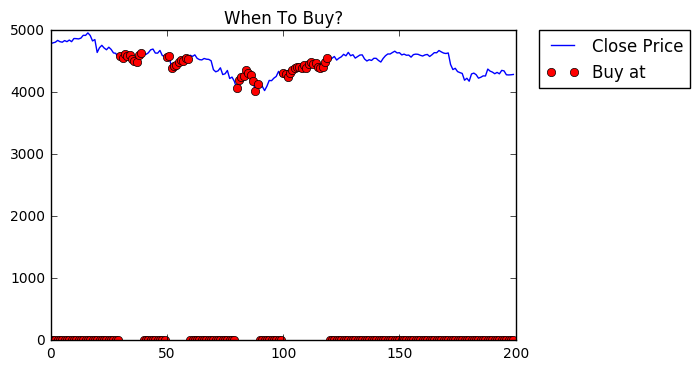

In [10]:
## Show the graph of result

data = [val for sublist in X_test for val in sublist]
# print("data: {}".format(data))

print("history data counts: {}".format(len(data)))

close_line= np.zeros(len(data), dtype=np.float)
for x in range(0,len(data)):
    close_line[x]=float(data[x])

# draw pic
plt.figure()
new_buy= np.zeros(len(close_line), dtype=np.float)
for i in range(0,len(rst_arr)):
    # new_buy[i*10]=rst_arr[i]*close_line[i*10]
    for j in range(0, 10):
        new_buy[i*10 + j]=rst_arr[i]*close_line[i*10 +j]
    
# for i in range(0,len(y_test)):
#    for j in range(0, 10):
#        new_buy[i*10 + j]=y_test[i]*close_line[i*10 + j]
# new_buy[i*10]=y_test[i]*close_line[i*10]
    
plt.plot(close_line,label='Close Price',linewidth=1,color=[0,0,1])
plt.plot(new_buy, 'ro',label='Buy at',linewidth=1,color=[1,0,0])
# plt.title("When To Buy?("+startDay+"~"+endDay+")")
plt.title("When To Buy?")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [12]:
## Let's convert this notebook to a README for the GitHub project's title page:
!jupyter nbconvert --to markdown CNN_Classifier_API.ipynb
!mv CNN_Classifier_API.md README.md

[NbConvertApp] Converting notebook CNN_Classifier_API.ipynb to markdown
[NbConvertApp] Support files will be in CNN_Classifier_API_files/
[NbConvertApp] Making directory CNN_Classifier_API_files
[NbConvertApp] Writing 16426 bytes to CNN_Classifier_API.md
